<a href="https://colab.research.google.com/github/Bibek4175/brain-tumor-detection/blob/main/tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install opendatasets
import opendatasets as od

In [18]:
od.download("https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation")

Skipping, found downloaded files in "./lgg-mri-segmentation" (use force=True to force download)


In [19]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [20]:
 #setting the height and width of image
im_width = 256
im_height = 256

Loading image and masks paths


In [21]:
image_filename_train = []
#creating a list of file containing word masks
mask_files = glob('/content/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

In [22]:
for i in mask_files:
    image_filename_train.append(i.replace('_mask',''))




In [23]:
image_filename_train[:10]

['/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_3.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_47.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_36.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_19.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_20.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_15.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_43.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_27.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_31.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_41.tif']

In [24]:
(mask_files)[:10]

['/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_3_mask.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_47_mask.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_36_mask.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_19_mask.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_20_mask.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_15_mask.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_43_mask.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_27_mask.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_31_mask.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_41_mask.tif']

In [25]:
len(image_filename_train)

3929

In [26]:
import cv2

In [27]:
def plot_from_img_path(rows,columns,list_img_path,list_mask_path):
    fig = plt.figure(figsize = (12,12))
    for i in range(1,rows * columns + 1):
        fig.add_subplot(rows,columns,i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask,alpha = 0.4)
    plt.show()

In [28]:
#plotting images and masks

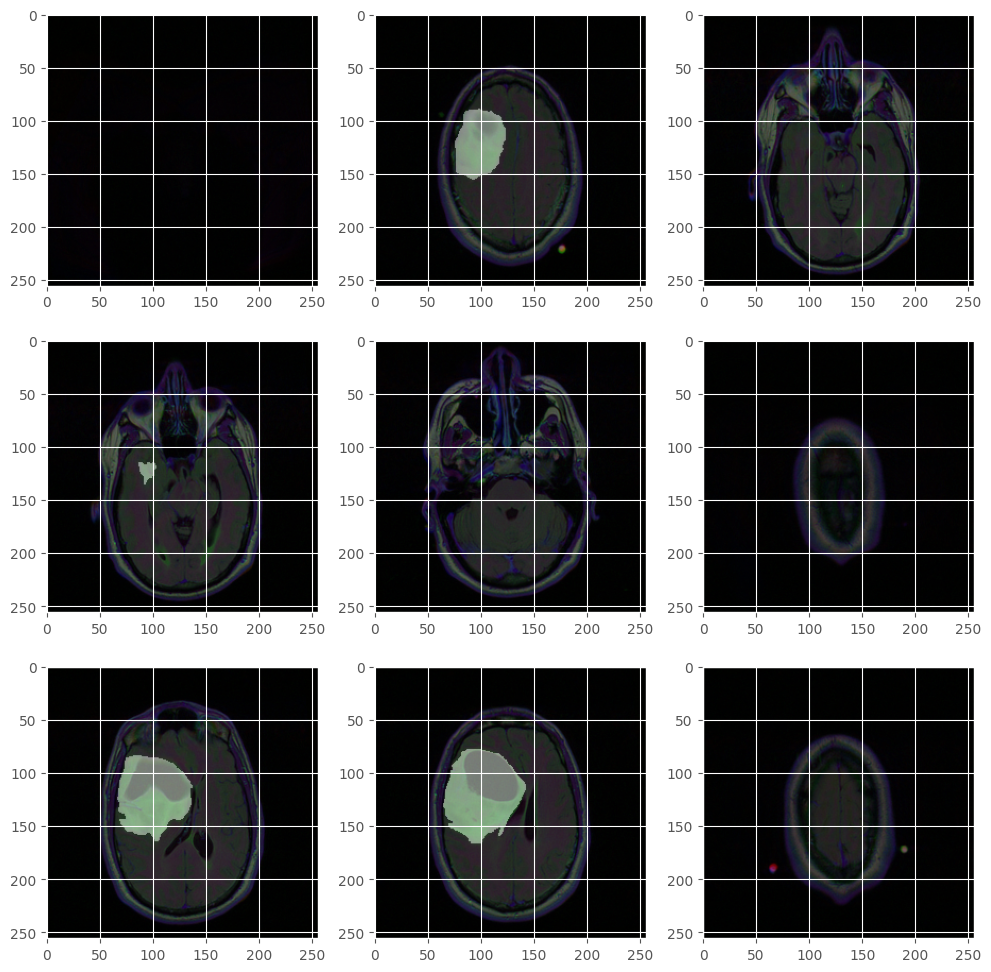

In [29]:
plot_from_img_path(3,3,image_filename_train,mask_files)

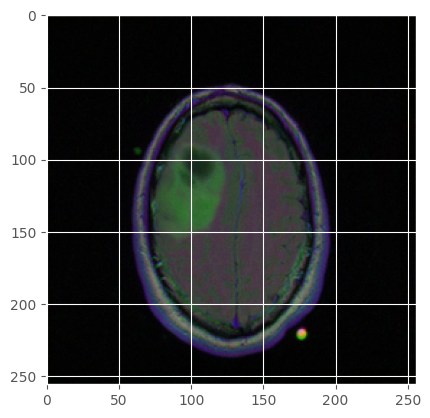

In [30]:
image = cv2.imread(image_filename_train[2])
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_files[2])
plt.imshow(image)
#plt.imshow(mask,alpha = 0.4)
plt.show()

Create data frame and spllit data on
train set test set and validation set

In [31]:
df = pd.DataFrame(data={'image_filenames_train':image_filename_train,'mask':mask_files})

In [32]:
df_train,df_test = train_test_split(df,test_size = 0.1)
df_train,df_val = train_test_split(df_train,test_size = 0.2)

In [33]:
print(df_test.shape)
print(df_val.shape)
print(df_train.shape)

(393, 2)
(708, 2)
(2828, 2)


In [34]:
### After normalization if value is less than 0.5 than the maski s ocnsidered black one ant there is not any tumor
def normalize_and_diagnose(img,mask):
    img = img/255
    mask = mask/255
    mask[mask>0.5]=1
    mask[mask<=0.5]=0
    return(img,mask)

In [42]:
# Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir="/content/working/",
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)

    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [36]:
def dice_coefficients(y_true,y_pred,smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten*y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return(2 * intersection + smooth)/(union + smooth)

def dice_coefficients_loss(y_true,y_pred,smooth=100):
    return -dice_coefficients(y_true,y_pred,smooth)

def iou(y_true,y_pred):
    intersection =K.sum(y_true * y_pred)
    summ= K.sum(y_true + y_pred)
    iou =(intersection + smooth)/(summ-intersection + smooth)
    return iou

def jaccard_distance(y_true,y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    return -iou(y_true_flatten,y_pred_flatten)


**UNET ARCHITECTURE**

In [37]:
EPOCHS = 30
BATCH_SIZE = 32
learning_rate = 1e-4
smooth = 100

In [38]:
def unet(input_size=(256, 256, 3)):
    """
    This function creates and returns a U-Net model. U-Net is a type of convolutional neural network
    designed for fast and precise segmentation of images. It consists of a contracting (downsampling)
    path and an expansive (upsampling) path, which gives it a U-shaped architecture.

    Parameters:
    -----------
    input_size : tuple of int
        The size of the input images. It is a 3-tuple for (height, width, channels).
        Default is (256, 256, 3).

    Returns:
    --------
    model : keras.models.Model
        The constructed U-Net model.
    """
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    up6 = concatenate(
        [
            Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn5
            ),
            conv4,
        ],
        axis=3,
    )
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate(
        [
            Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn6
            ),
            conv3,
        ],
        axis=3,
    )
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate(
        [
            Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn7
            ),
            conv2,
        ],
        axis=3,
    )
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate(
        [
            Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn8
            ),
            conv1,
        ],
        axis=3,
    )
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [43]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.83,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip = True,
                            fill_mode='nearest'
)
train_gen = train_generator(df_train,BATCH_SIZE,train_generator_param,target_size=(im_height,im_width))
test_gen = train_generator(df_val,BATCH_SIZE,dict(),target_size=(im_height,im_width))
model = unet(input_size=(im_height,im_width,3))
optimizer = Adam(learning_rate=learning_rate,beta_1=0.9,beta_2=0.999,epsilon=1e-8,amsgrad=False)
model.compile(optimizer=optimizer,loss=dice_coefficients_loss,metrics=['binary_accuracy',iou,dice_coefficients])
callbacks = [ModelCheckpoint('unet.hdf5',verbose=1,save_best_only=True)]
history = model.fit(train_gen,
                   steps_per_epoch=len(df_train)/BATCH_SIZE,
                   epochs=EPOCHS,
                   callbacks=callbacks,
                   validation_data=test_gen,
                   validation_steps=len(df_val)/BATCH_SIZE
)


Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/30
89/88 [==============================] - ETA: -1s - loss: -0.0778 - binary_accuracy: 0.9177 - iou: 0.0418 - dice_coefficients: 0.0785Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02443, saving model to unet.hdf5
88/88 [==============================] - 276s 2s/step - loss: -0.0778 - binary_accuracy: 0.9177 - iou: 0.0418 - dice_coefficients: 0.0785 - val_loss: -0.0244 - val_binary_accuracy: 0.9868 - val_iou: 0.0120 - val_dice_coefficients: 0.0235
Epoch 2/30
89/88 [==============================] - ETA: -1s - loss: -0.1392 - binary_accuracy: 0.9859 - iou: 0.0761 - dice_coefficients: 0.1395
Epoch 2: val_loss improved from -0.02443 to -0.02747, saving model to unet.hdf5
88/88 [==============================] - 182s 2s/step - loss: -0.1392 - binary_accuracy: 0.9859 - iou: 0.0761 - dice_coefficients: 0.1395 - val_loss: -0.0275 - val_bin

In [46]:
import pprint
pprint.pprint(history.history)

{'binary_accuracy': [0.9177379012107849,
                     0.9859485626220703,
                     0.9879306554794312,
                     0.9923050999641418,
                     0.9918878674507141,
                     0.9937301874160767,
                     0.9951019287109375,
                     0.9952746629714966,
                     0.995972216129303,
                     0.9963501691818237,
                     0.9965403079986572,
                     0.99677574634552,
                     0.9966782927513123,
                     0.9969431757926941,
                     0.9973356127738953,
                     0.9973206520080566,
                     0.997372567653656,
                     0.9974873065948486,
                     0.9974867105484009,
                     0.9977436661720276,
                     0.9973071217536926,
                     0.9975565075874329,
                     0.9978733658790588,
                     0.997836172580719,
                     

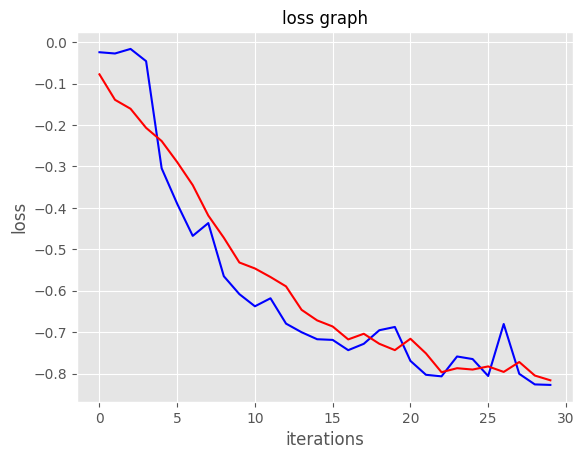

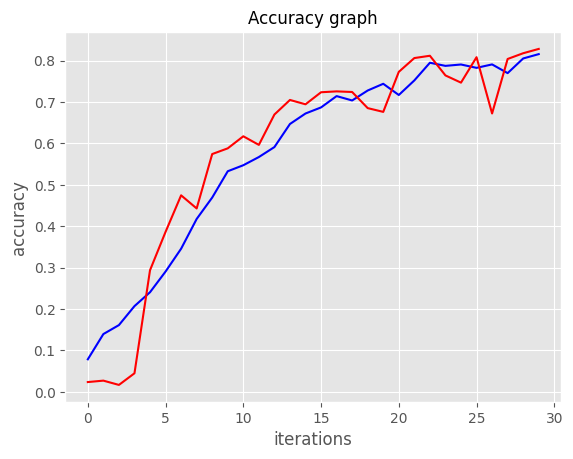

In [55]:
history_past_training = history.history
train_dice_coeff = history_past_training['dice_coefficients']
list_test = history_past_training['val_dice_coefficients']
train_jaccard_list = history_past_training['iou']
test_jacard_list = history_past_training['val_iou']
train_loss_list = history_past_training['loss']
test_loss_list = history_past_training['val_loss']
plt.figure(1)
plt.plot(test_loss_list,'b-')
plt.plot(train_loss_list,'r-')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph',fontsize = 12)
plt.figure(2)
plt.plot(train_dice_coeff,'b-')
plt.plot(list_test,'r-')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph',fontsize = 12)
plt.show()


In [ ]:
train_gen.sh

In [ ]:
tf.debugging.disable_traceback_filtering()`

In [ ]:
!zip -r file.zip /kaggle/working